In [4]:
import numpy as np

class Particle: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, xx, yy, dim, minx, maxx):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
    
    
        self.best_particle_pos = self.position
        self.dim = dim
        
        self.xx = xx
        self.yy = yy
        
        print(self.position)
        self.fitness = loss_function(self.xx, self.position, self.yy)
        print(self.fitness)
        
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = loss_function(self.xx, self.position, self.yy)
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level 
        return inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)

    
class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, dim, population_size, time_steps, search_range):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        self.w = w # Inertia
        self.a1 = a2 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.dim = dim
        
        xx1 = np.random.multivariate_normal(mean=[2,2], cov=[[1,0],[0,1]], size = 100)
        yy1 = np.ones(shape=(xx1.shape[0], 1))
        xx0 = np.random.multivariate_normal(mean=[-2,-2], cov=[[1,0],[0,1]], size = 100)
        yy0 = -np.ones(shape=(xx0.shape[0], 1))

        self.xx = np.vstack([xx1, xx0])
        self.yy = np.vstack([yy1, yy0])

        print(search_range)
        self.swarm = [Particle(self.xx, self.yy, dim, -search_range, search_range) for i in range(population_size)]
        self.time_steps = time_steps
        print('init')

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100
        

    def run(self):
        for t in range(self.time_steps):
            for p in range(len(self.swarm)):
                particle = self.swarm[p]

                new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, particle.best_particle_pos, self.best_swarm_pos)
                                
                if new_position@new_position > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                    print('Time:', t,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                    raise SystemExit('Most likely divergent: Decrease parameter values')
 
                self.swarm[p].setPos(new_position)

                new_fitness = loss_function(self.xx, new_position, self.yy)
                if new_fitness < self.best_swarm_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position

            if t % 100 == 0: #we print only two components even it search space is high-dimensional
                print("Time: %6d,  Best Fitness: %14.6f,  Best Pos: %9.4f,%9.4f" % (t,self.best_swarm_fitness,self.best_swarm_pos[0],self.best_swarm_pos[1]), end =" ")
                if self.dim>2: 
                    print('...')
                else:
                    print('')

In [29]:
def loss_function(xx, ww, dd):
    return np.sum(np.abs(dd-perceptron(ww, xx)))/len(dd)

In [30]:
def perceptron(ww, xx):
    yy = 1/(1+np.exp(-np.dot(ww,xx.T)))[:,None]
    for i in range(len(yy)):
        if yy[i] >= 0.5:
            yy[i] = 1
        else:
            yy[i] = -1
    return yy

In [33]:
xx1 = np.random.multivariate_normal(mean=[2,2], cov=[[1,0],[0,1]], size = 100)
yy1 = np.ones(shape=(xx1.shape[0], 1))
xx0 = np.random.multivariate_normal(mean=[-2,-2], cov=[[1,0],[0,1]], size = 100)
yy0 = -np.ones(shape=(xx0.shape[0], 1))


xx = np.vstack([xx1, xx0])
yy = np.vstack([yy1, yy0])
ww = np.random.uniform(low=-1, high=1, size=2)

loss_function(xx,ww,yy)

1.82

In [34]:
PSO(dim=2, w=0.7, a1=2.02, a2=2.02, population_size=30, time_steps=1001, search_range=1).run()

1
[0.76146471 0.42332772]
0.0
[-0.57339794  0.79362386]
0.64
[-0.82966975 -0.47782242]
2.0
[-0.55051263  0.97416202]
0.41
[-0.6579861  -0.11659071]
2.0
[0.22106165 0.74989454]
0.01
[-0.29469254 -0.46247303]
2.0
[-0.77863561 -0.49964722]
2.0
[ 0.32783954 -0.12817038]
0.2
[0.0330451  0.40644539]
0.02
[-0.21316114 -0.86161369]
1.98
[-0.59861952  0.69313211]
0.88
[ 0.73327886 -0.5322751 ]
0.63
[ 0.00325701 -0.08183741]
1.95
[0.35801886 0.39317196]
0.0
[-0.04304226 -0.14236634]
1.99
[0.86972056 0.10371688]
0.0
[ 0.07422645 -0.79398295]
1.92
[-0.26455232 -0.99767882]
1.99
[-0.62317564  0.22926645]
1.82
[-0.58131121  0.83991766]
0.6
[-0.04085057 -0.02341079]
2.0
[-0.15162217  0.03165414]
1.91
[-0.43800627  0.54670824]
0.75
[ 0.22755719 -0.40827333]
1.6
[ 0.26843697 -0.78954631]
1.83
[-0.55999854  0.72882355]
0.71
[0.03703578 0.57050824]
0.02
[0.21495986 0.63718073]
0.0
[0.29059925 0.67725598]
0.0
init
Time:      0,  Best Fitness:       1.990000,  Best Pos: -449.3039,  -7.9870 


<ipython-input-30-40301074679b>:2: RuntimeWarning: overflow encountered in exp
  yy = 1/(1+np.exp(-np.dot(ww,xx.T)))[:,None]


Time:    100,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    200,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    300,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    400,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    500,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    600,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    700,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    800,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:    900,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 
Time:   1000,  Best Fitness:       0.000000,  Best Pos:  203.8322, 181.8268 


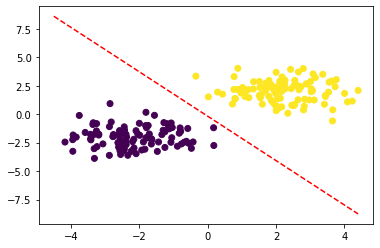

In [95]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

xx1 = np.random.multivariate_normal(mean=[2,2], cov=[[1,0],[0,1]], size = 100)
yy1 = np.ones(shape=(xx1.shape[0], 1))
xx0 = np.random.multivariate_normal(mean=[-2,-2], cov=[[1,0],[0,1]], size = 100)
yy0 = -np.ones(shape=(xx0.shape[0], 1))


xx = np.vstack([xx1, xx0])
yy = np.vstack([yy1, yy0])

ax, fig = plt.subplots()

def function(x):
    return (322/-165)*x +29/-165

x_S = [x/10 for x in range(-45,45)]

y = [function(x) for x in x_S]

fig.scatter(xx[:,0][:,None],xx[:,1][:,None],c=yy)
fig.plot(x_S,y,c='r',linestyle='dashed')